This notebook performs cohort-based retention analysis to examine user behavior over time. Users are grouped into cohorts based on their signup or first-activity month, and retention matrices are built to measure how long users remain active. The notebook visualizes retention curves and heatmaps to identify patterns in user decay and differences in engagement across cohorts.

## Load Cleaned Events Data

In [1]:
import pandas as pd

df = pd.read_csv("/Users/quynhnguyen/Documents/User Churn Project/Data/events_clean_oct.csv")
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(['user_id','event_time'])


## Compute Retention Rate

In [8]:
# Define first_seen & cohort week
if 'cohort_week' in df.columns:
    df = df.drop(columns=['cohort_week'])

user_first = df.groupby('user_id')['event_time'].min().reset_index()
user_first['cohort_week'] = user_first['event_time'].dt.to_period('W').astype(str)

df = df.merge(user_first[['user_id','cohort_week']], on='user_id', how='left')


In [9]:
# Compute activity week
df['activity_week'] = df['event_time'].dt.to_period('W').astype(str)

# Cohort retention table
cohort = df.groupby(['cohort_week','activity_week'])['user_id'].nunique().reset_index()
cohort_pivot = cohort.pivot(index='cohort_week', columns='activity_week', values='user_id')

# Compute cohort sizes correctly (each cohort's own first active week)
cohort_sizes = cohort_pivot.apply(lambda row: row[row.first_valid_index()], axis=1)

# Divide each row by its own cohort size
retention = cohort_pivot.divide(cohort_sizes, axis=0)
retention = retention.fillna(0)

retention.head()


activity_week,2019-09-30/2019-10-06,2019-10-07/2019-10-13,2019-10-14/2019-10-20,2019-10-21/2019-10-27,2019-10-28/2019-11-03
cohort_week,,,,,
2019-09-30/2019-10-06,1.0,0.417277,0.375755,0.325341,0.203821
2019-10-07/2019-10-13,0.0,1.000000,0.340872,0.277444,0.159164
2019-10-14/2019-10-20,0.0,0.000000,1.000000,0.298683,0.151799
2019-10-21/2019-10-27,0.0,0.000000,0.000000,1.000000,0.182456
2019-10-28/2019-11-03,0.0,0.000000,0.000000,0.000000,1.000000


## Plot Cohort Heatmap and Retention Curve

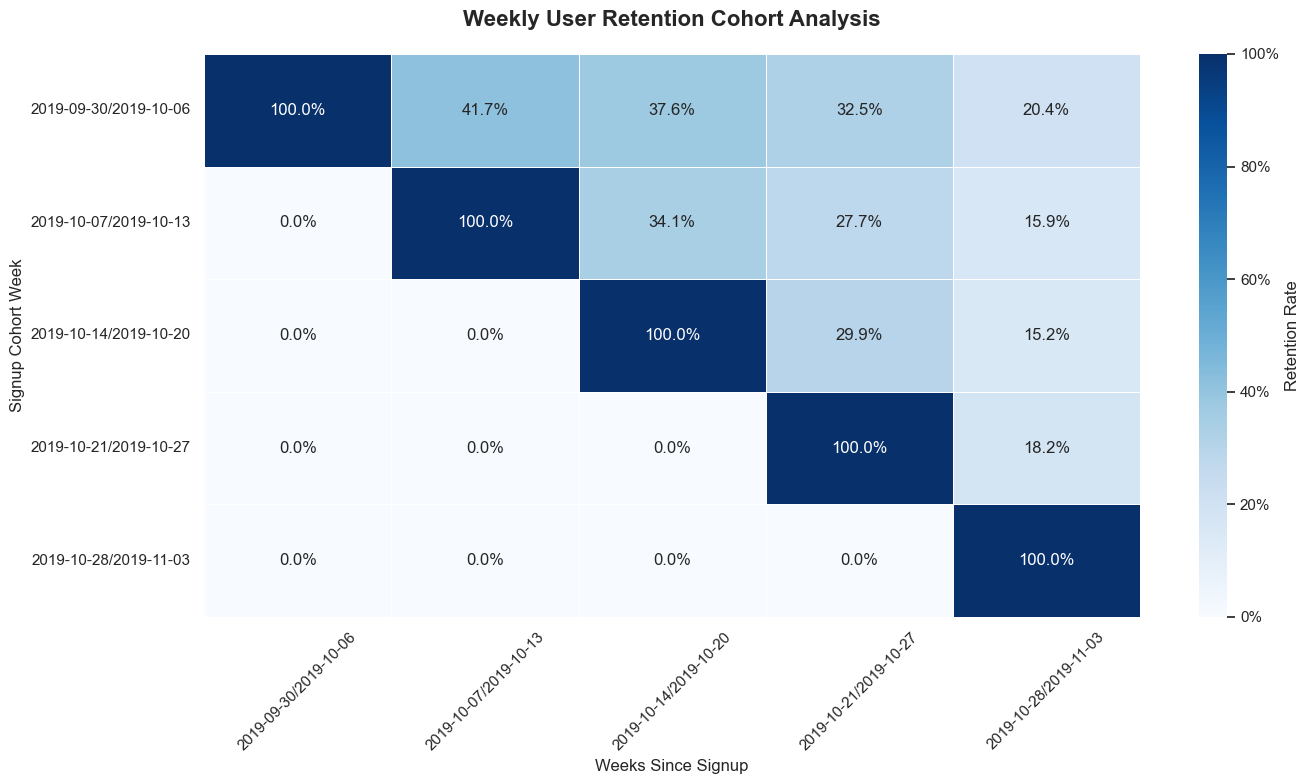

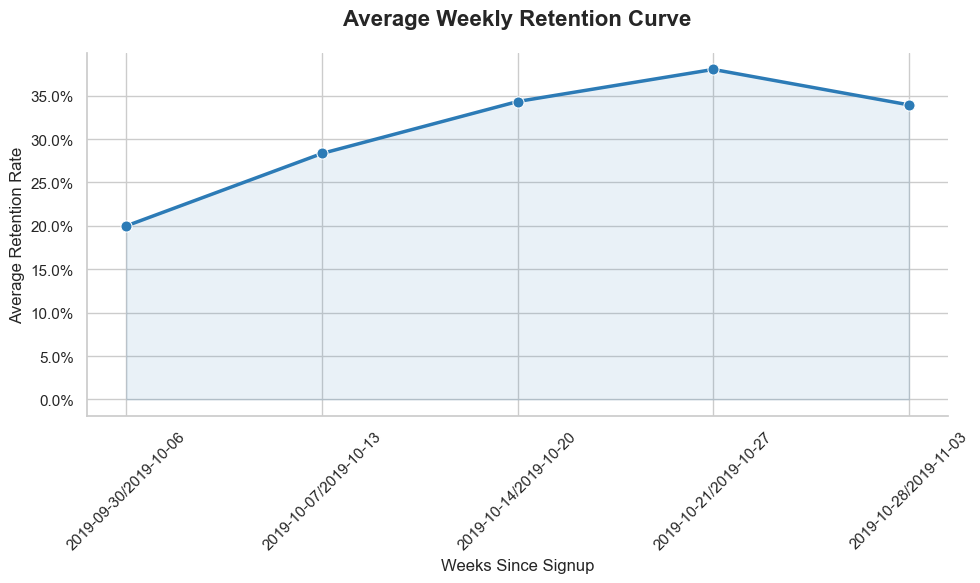

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Cohort Heatmap
plt.figure(figsize=(14, 8))
sns.set_theme(style="white")

ax = sns.heatmap(
    retention, 
    annot=True,          # Show the numbers
    fmt=".1%",           # Format as percentage with 1 decimal
    cmap="Blues",       # Set color palette
    linewidths=.5,       # Add spacing between cells
    cbar_kws={'label': 'Retention Rate', 'format': mtick.PercentFormatter(1.0)}
)

plt.title("Weekly User Retention Cohort Analysis", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Weeks Since Signup", fontsize=12)
plt.ylabel("Signup Cohort Week", fontsize=12)

# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()

# Retention Curve (average)
avg_retention = retention.mean(axis=0)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Plotting with improved line and markers
sns.lineplot(
    x=avg_retention.index, 
    y=avg_retention.values, 
    marker='o', 
    markersize=8, 
    linewidth=2.5, 
    color='#2c7bb6'
)

# Add a subtle area fill for better visual weight
plt.fill_between(avg_retention.index, avg_retention.values, alpha=0.1, color='#2c7bb6')

plt.title("Average Weekly Retention Curve", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Average Retention Rate", fontsize=12)
plt.xlabel("Weeks Since Signup", fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Rotate x-axis labels 45 degrees
plt.xticks(avg_retention.index, rotation=45)

sns.despine() # Remove top and right spines
plt.tight_layout()